In [75]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import geopandas as gpd
%matplotlib inline 

# New York City Parking Ticket Analysis (Fiscal Year 2015 - 2017)
## Table of Contents
<ul>
    <li><a href = '#Introduction'>Introduction</a></li>
    <li><a href = '#Preparation: Initial dataset loading'>Preparation: Initial dataset loading</a></li>
    <li><a href = '#1'>1. Overview - Distribution of parking tickets issued over the fiscal year. (2015, 2016, 2017)</a></li>
    <li><a href = '#2'>2. Distribution of the Traffic Tickets Issued on Different Day of the Week</a></li>
    <li><a href = '#3'>3. Total Ticket Issued on Different Hours of the Day</a></li>
    <li><a href = '#4'>4. Total Tickets and Violation Codes</a></li>
    <li><a href = '#5'>5. Total Ticket with Violation Code 21, 36, 38 Issued on Different Hours of the Day</a></li>
    <li><a href = '#6'>6. Remove the data with violation code 21</a></li>
    <li><a href = '#7'>7. Total Tickets and Plate Types</a>
    <li><a href = '#8'>8. Total Tickets Issued by Each Precinct of NYC </a></li>
<ul>

<a id = 'Introduction'></a>
## Introduction

The NYC Department of Finance collects data on every parking ticket issued in NYC every year. (~10M per year!). This data is made publicly available to aid in ticket resolution and to guide policymakers. There are three csv files (~2.1GB each), covering Aug 2014-June 2017. The files are roughly organized by fiscal year. (July 1 - June 30) Columns include information about the types of vehicle, the time and location a ticket was issued, etc.

Original Dataset can be assessed through the following links:
1. Parking Violations Issued - Fiscal Year 2015 (https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2015/c284-tqph)
2. Parking Violations Issued - Fiscal Year 2016 (https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2016/kiv2-tbus)
3. Parking Violations Issued - Fiscal Year 2017 (https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2017/2bnn-yakx)

<a id = 'Preparation: Initial dataset loading'></a>
## Preparation: Initial dataset loading


In [76]:
#Load Dataset from Fiscal Year 2015, 2016 and 2017
#This could be modified to load one single dataset, simply put a single value inside the year list
#These are big files so they might take some time to load, when the loading is done, a word 'done' will be printed
years = [2015, 2016, 2017]
raw_data_151617 = []

def loading_file(year, i):
    filename = "Parking_Violations_Issued_-_Fiscal_Year_" + str(year) + ".csv"
    print("loading data", filename, "...")
    raw_data = pd.read_csv(filename, low_memory = False)
    raw_data_151617.append(raw_data)
    print('done!')

for year,i in zip(years, range(3)):
    loading_file(year,i)

loading data Parking_Violations_Issued_-_Fiscal_Year_2015.csv ...
done!
loading data Parking_Violations_Issued_-_Fiscal_Year_2016.csv ...
done!
loading data Parking_Violations_Issued_-_Fiscal_Year_2017.csv ...
done!


In [77]:
#NYC fiscal year starts from July to June next year
start_dates = []
end_dates = []
for year in years:
    start_dates.append(str(year-1) + "-07-01")
    end_dates.append(str(year) + "-06-30")

<a id = '1'></a>
## 1. Overview - Distribution of parking tickets issued over the fiscal year. (2015, 2016, 2017)

Since all three datasets has been loaded into the list 'raw_data_15_17', now we can access the parking ticket data from 2015 at raw_data_15_17[0]. 

Let's take a quick look to see what we have in the dataset loaded:-)

In [78]:
raw_data_151617[0].head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Hydrant Violation,Double Parking Violation,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
0,8002531292,EPC5238,NY,PAS,10/01/2014,21,SUBN,CHEVR,T,20390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8015318440,5298MD,NY,COM,03/06/2015,14,VAN,FRUEH,T,27790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7611181981,FYW2775,NY,PAS,07/28/2014,46,SUBN,SUBAR,T,8130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7445908067,GWE1987,NY,PAS,04/13/2015,19,4DSD,LEXUS,T,59990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7037692864,T671196C,NY,PAS,05/19/2015,19,4DSD,CHRYS,T,36090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
raw_data_151617[0].count()

Summons Number                       11809233
Plate ID                             11806902
Registration State                   11809233
Plate Type                           11809233
Issue Date                           11809233
Violation Code                       11809233
Vehicle Body Type                    11763417
Vehicle Make                         11733713
Issuing Agency                       11809233
Street Code1                         11809233
Street Code2                         11809233
Street Code3                         11809233
Vehicle Expiration Date              11809233
Violation Location                   10010063
Violation Precinct                   11809233
Issuer Precinct                      11809233
Issuer Code                          11809233
Issuer Command                       10025775
Issuer Squad                         10025598
Violation Time                       11807518
Time First Observed                   1227444
Violation County                  

After I wents through all the columns of the orginal dataset, I have decided to keep the columns that have similar number of entries as the Summons Number column. The reasoning is that, the entries at the Summons Number column is unique to each ticket issued, and should always be presented on the ticket, therefore, it is unlikely for it to have a invalid or missing data entry. Therefore, if we include any data columns that has a significant smaller number of entry than the Summons Number column will give us a biased view of the dataset. In addition to the above consideration, I have also decided to pick the columns that supposedly have the best representation of different criterias of the dataset that they help us answer the questions of 'when?', 'how?', 'who?', and 'where?'. 

In [80]:
data_151617 = []
for raw_data in raw_data_151617:
    data = raw_data[['Violation Time','Summons Number','Plate Type','Issue Date', 'Violation Code','Issuer Precinct'  ]]
    data.fillna(-1)
    data_151617.append(data)

The first thing I want to do is to get a general impression of how the number of parking tickets distributed throughout each fiscal year. For New York City, the fiscal year starts from July 1st of the previous year to June 30th of the current year. For example, fiscal year 2015 starts from July 1st, 2014 and ends on June 30th, 2015.

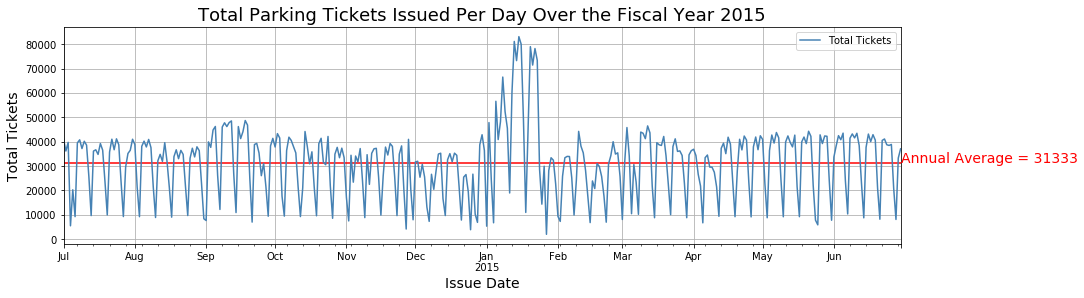

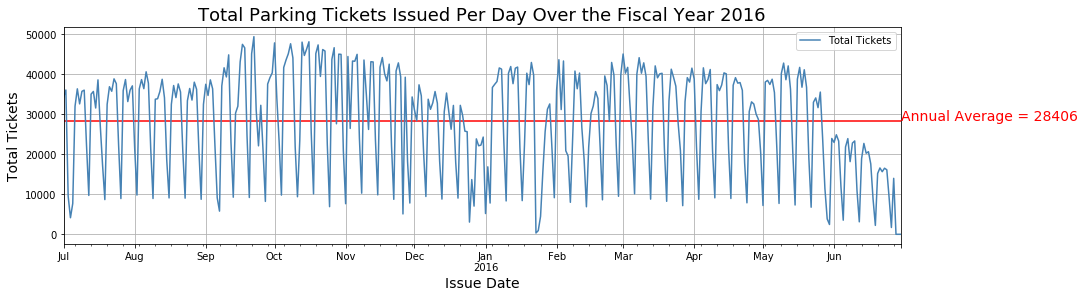

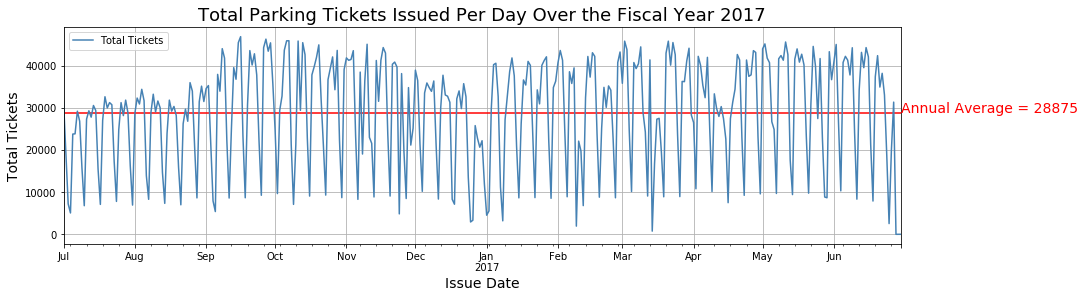

In [83]:
Date_Total_list = [] #This list will be used for the violin plots later

for data, year, start_date, end_date in zip(data_151617, years, start_dates, end_dates):
    #Data Cleaning Section
    Date_Total = data[['Issue Date','Summons Number']].groupby('Issue Date', as_index = False).count() 
    Date_Total['Issue Date'] = pd.to_datetime(Date_Total['Issue Date'])
    Date_Total = Date_Total.set_index('Issue Date').loc[start_date : end_date].sort_index().rename(columns = {"Summons Number" : "Total Tickets"})
    
    #Graph Section
    fig = plt.figure(figsize = (15,4))
    ax = fig.add_subplot(1,1,1)
    Date_Total.plot(ax = ax, kind = 'line', color = 'steelblue', grid = True, figsize = (15,4))
    ax.hlines(y = Date_Total['Total Tickets'].mean(), xmin = start_date, xmax = end_date, color = 'red', )
    plt.text(end_date, Date_Total['Total Tickets'].mean(), ("Annual Average = " + str(int(Date_Total['Total Tickets'].mean()))), color = 'red', fontsize = 14)
    plt.title("Total Parking Tickets Issued Per Day Over the Fiscal Year " + str(year), fontsize = 18 )
    ax.set_xlabel('Issue Date', fontsize = 14)
    ax.set_ylabel('Total Tickets',fontsize = 14)
    
    #This line is used for preparing the dataset for the violin plots later
    Date_Total_list.append(Date_Total)
    
    #This section is to prepare the dataset for the combined plot later (all three years)
    if year == 2015:
        Date_Total_all_years = Date_Total.rename(columns = {"Total Tickets" : "2015"}) 
        Date_Total_all_years = Date_Total_all_years.reset_index()
    else:
        # we need to remove the unique 02-29 data point so that dates after can match the positions of other years 
        if year == 2016:
            Date_Total = Date_Total.drop(pd.to_datetime('2016-02-29'))
        Date_Total = Date_Total.reset_index()
        Date_Total_all_years[str(year)] = Date_Total['Total Tickets']
        Date_Total = Date_Total.set_index('Issue Date')

By looking at the above three graphs we could get some quick impressions:
1. The daily average of the parking tickets issued (indicated by the red line) does not change too much from fiscal year to fiscal year. It looks like it is flactuating around the level of 30,000 tickets/day.
2. There is no obvious trend showing that there are big changes from month to month. Expect for fiscal year 2015, we are able to see a big increase in January.
3. On the other hand, we are able to observe seemly big periodical fluctutions happaning within each month. We can see that there are around four peaks for each month, which matches the number of weeks in a month roughly. This could implies that the total number of parking tickets issued is fluctuating significantly on different weekdays.
4. There seems to be a small drop within most peaks observed. 

Next, we will combine the datasets for all three years togather to see whether the above observations still stands.

In [84]:
#Prepare the the dataset for combined plot
Date_Total_all_years = Date_Total_all_years.set_index('Issue Date')
Date_Total_all_years['Average'] = Date_Total_all_years.mean(axis = 1)
Date_Total_all_years['std'] = Date_Total_all_years[['2015','2016','2017']].std(axis = 1)
Date_Total_all_years['Average+'] = Date_Total_all_years['Average'] + Date_Total_all_years['std']
Date_Total_all_years['Average-'] = Date_Total_all_years['Average'] - Date_Total_all_years['std']

Text(0, 0.5, 'Total Tickets')

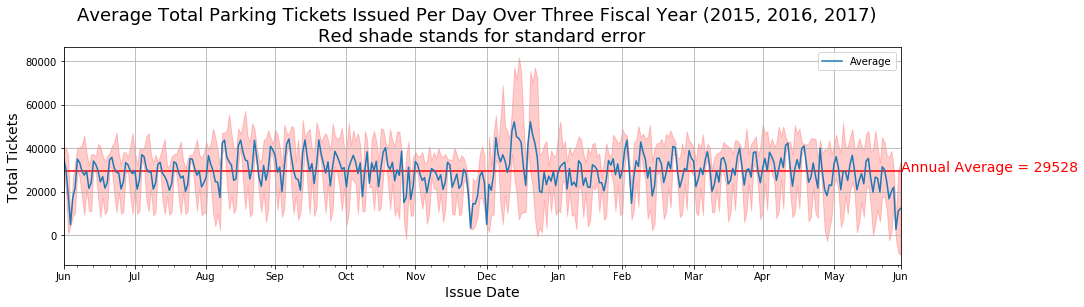

In [89]:
fig2 = plt.figure(figsize = (20,8))
ax2 = fig2.add_subplot(1,1,1)
ax2 = Date_Total_all_years[['Average']].plot(ax = ax2, kind = 'line', figsize = (15,4), alpha = 1, grid = True)
plt.fill_between(Date_Total_all_years.index, Date_Total_all_years['Average+'], Date_Total_all_years['Average-'], alpha = 0.2, color = 'red', label = 'std' )
ax2.hlines(y = Date_Total_all_years['Average'].mean(), xmin = start_dates[0], xmax = end_dates[0], color = 'red')
plt.text(end_dates[0], Date_Total_all_years['Average'].mean(), ("Annual Average = " + str(int(Date_Total_all_years['Average'].mean()))), color = 'red', fontsize = 14)
plt.title("Average Total Parking Tickets Issued Per Day Over Three Fiscal Year (2015, 2016, 2017)  \nRed shade stands for standard error", fontsize = 18 )
ax2.xaxis.set_major_formatter(dates.DateFormatter('%b'))
ax2.set_xlabel('Issue Date', fontsize = 14)
ax2.set_ylabel('Total Tickets',fontsize = 14)

After averaged the data gathered for all three years, we can see that:
1. The total tickets issued over the fiscal year since to be very stable, no big changes between months.
2. The number of tickets issued daily seems to fluctuating around the annual average periodically.
3. The small drop within each peak disappears, which indicated they might be just some random fluctuations exist in the individaul dataset.

Now, let's focus on the observation 2 and take a deeper look at the distribution of the the daily parking ticket data in each fiscal year. 

<a id = '2'></a>
## 2. Distribution of the Traffic Tickets Issued on Different Day of the Week


As we mentioned before, we are able to see big periodical fluctutions happaning within each month. In addition, we can see that there are roughly four peaks for each month, which matches the number of weeks in a month roughly. So, one hypothesis we could have is that the the total tickets issued matches a certain pattern based on the day of the week. To investigate this, we are going to used violin plots to look at the distribution of the data points based on different weekdays.

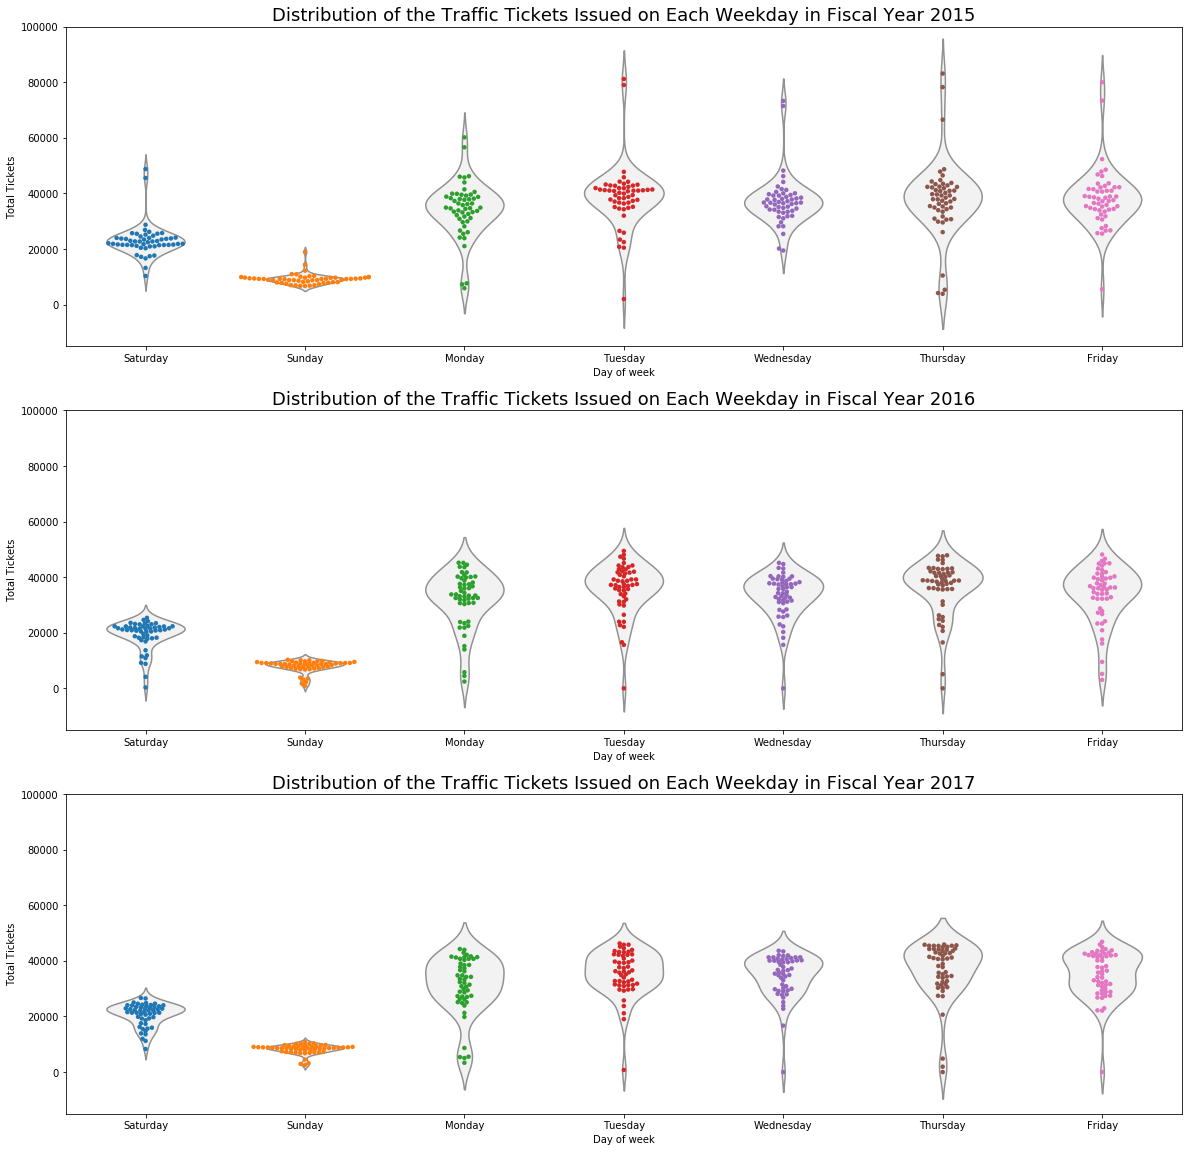

In [90]:
#Violain Plots for individual years by WeekDays
fig4, axes4 = plt.subplots(3,1, figsize = (20,20))
for Date_Total, year, i in zip(Date_Total_list, years, range(3)):  
    Date_Total["Day of week"] = Date_Total.index.day_name()
    #violin plot for the number of tickets gave out on each weekday
    sns.violinplot(ax = axes4[i], x = "Day of week", y = "Total Tickets", data = Date_Total, height = 2.5, width = 0.5, order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], scale = 'count', inner = None, color = "0.95")
    sns.swarmplot(ax = axes4[i], x = "Day of week", y = "Total Tickets", data = Date_Total, order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], size = 4.5)
    axes4[i].set_title('Distribution of the Traffic Tickets Issued on Each Weekday in Fiscal Year ' + str(year), fontsize = 18)    
    axes4[i].set_ylim(-15000, 100000)

From the above violin plots, we can see that from Monday to Friday, the total amount parking tickets issued on that day are distributed at the similar level (20000~45,000 tickets) for all three fiscal years, except for only a few data points that have deviated from the region and are distributed at the the high end (~80,000 tickets) and low end region instead. (~10,000 tickets) On the other hand, the total amount of tickets issued per day dropped signficantly on weekends, expecially on Sunday. This is a very reasonable finding while considering that part of the parking rules in NYC are not enforced on weekends expecially on Sunday (e.g. Pakring meters, or simply we are having less traffic law enforcement officers on duty)

Now we known that Sunday is the day with the lowest number of parking tickets issued, but what about the number of tickets issued at different hours on the same day? Well, let's investigate ;-)

<a id = '3'></a>
## 3. Total Ticket Issued on Different Hours of the Day

In [91]:
#Function to clean the Violation time input, it will convert '1000P' original entry to a datetime object '1960-01-01-20'. If invalid character
#presents, return -1
def cleanViolationTime(input):
    try:
        h, m, A_P = int(input[0:2]), int(input[2:4]), input[4]
        if A_P not in ['A','P']:
            return -1
        else:
            if A_P == 'P':
                if h == 12:
                    h = 0
                h = (h + 12)
            if A_P == 'A' and h == 12:
                h = 0
            if A_P == 'A': 
                h = h
            return pd.to_datetime("1960-01-01 " + str(h) + ":"+str(m))
    except:
        return -1

In fiscal year 2015 the average number of parking tickets Issued per minute is 8199
In fiscal year 2016 the average number of parking tickets Issued per minute is 7376
In fiscal year 2017 the average number of parking tickets Issued per minute is 7501


Text(0.5, 1.0, 'Total Ticket Issued on Different Hours of the Day')

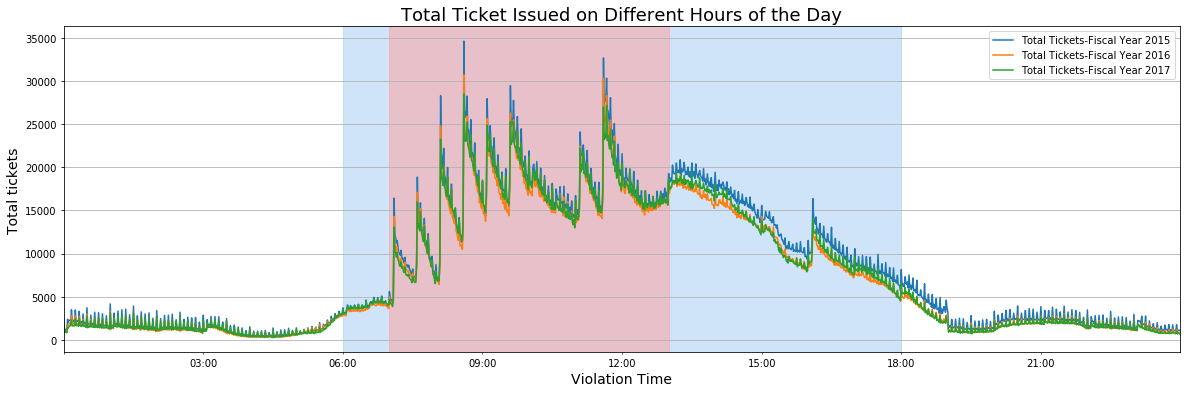

In [92]:
fig5 = plt.figure(figsize = (20,6))
ax = fig5.add_subplot(1,1,1)
for data, year, start_date, end_date in zip(data_151617, years, start_dates, end_dates):
    #Cleanning the dataset
    hour_data = data[['Violation Time', 'Summons Number']].groupby(['Violation Time'], as_index = False).count()
    hour_data = hour_data.loc[hour_data['Summons Number'] > 10] #I found this is a very effective way to filter all invalid data entries since they are all infrequent events.
    hour_data['Cleaned Violation Time'] = hour_data['Violation Time'].apply(cleanViolationTime)
    hour_data = hour_data.loc[hour_data['Cleaned Violation Time'].dt.year == 1960].groupby('Cleaned Violation Time').sum()
    hour_data = hour_data.rename(columns = {'Summons Number' : ('Total Tickets-Fiscal Year ' + str(year))})
    #graph section
    hour_data.plot(ax = ax, kind = 'line', grid = True, alpha = 1)
    ax.set_xlabel("Violation Time", fontsize = 14)
    ax.set_ylabel("Total tickets", fontsize = 14)
    ax.xaxis.set_major_locator(dates.HourLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
    print("In fiscal year", str(year), "the average number of parking tickets Issued per minute is", str(int(hour_data[('Total Tickets-Fiscal Year ' + str(year))].sum()/1440)))
ax.axvspan('1960-01-01 06:00','1960-01-01 18:00', alpha = 0.5, color = 'b' )
ax.axvspan('1960-01-01 07:00','1960-01-01 13:00', alpha = 0.5, color = 'r' )
plt.title('Total Ticket Issued on Different Hours of the Day', fontsize = 18)
    

As we can see from above, there are couple very interesting characteristics of this graph that is hard to be overlooked:
1. the majority of the tickets issued are from the 6:00AM to 6:00PM window. (Blue region)
2. From 7:00AM to 1:00PM (red area), there seems to have exctly one peak appears in every 30 mins. What is causing those?
3. The plots that generated from three different fiscal years are remarkably similar. Why is that?

To address question 2 and 3, we might have to make some educated guesses here. First, the pattern of the plot from three different years are almost identical. Therefore, I believe it is safe for us to conclude that this pattern is likely caused by something intrinsic of the system rather than by some random variation of the data. we can see that the big peaks are only happend in the morning and each of them are roughly 30 mins apart. Well, this time interval is rather specific. In NYC, for the parking rules enforced that could potentially be 30 mins apart... well, one of the possible candidate is our nation-wide famous 'Alternate Side Parking' or 'Street Cleaning' rule. Just by a quick glimpse of the 'Alternate Side Parking Map of NYC' (NYC ASP Street Parking Map: https://www.freeparknyc.com/), it is not hard to find that most of the street cleanning time listed are in the window from 7:00 AM to 1:00PM (e.g. 8:30AM-10:00AM and 9:30AM-11:AM). 

Luckly, the dataset we have does contain a specific column for violation codes, which states the reason why the ticket was issued. Now, let's see what's the total tickets issued with each violation code.

<a id = '4'></a>
## 4. Total Tickets and Violation Codes

Text(0, 0.5, 'Violation Code')

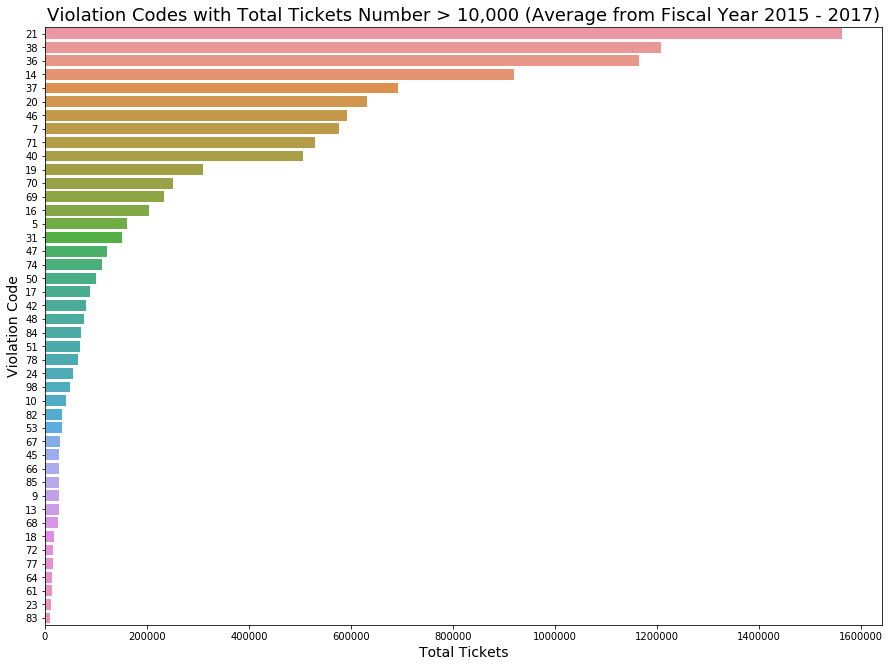

In [93]:
#Data Preparation 
v_code_data_list = []
for data, year, start_date, end_date in zip(data_151617, years, start_dates, end_dates):
    v_code_data = data[['Violation Code','Summons Number']].groupby('Violation Code').count()
    v_code_data_list.append(v_code_data[1:100])
    
#Graph Section
fig = plt.figure(figsize = (15,11))
ax = fig.add_subplot(1,1,1)
v_code_data_avg = (v_code_data_list[0]+v_code_data_list[1]+v_code_data_list[2])/3
v_code_data_avg = v_code_data_avg.reset_index().sort_values('Summons Number', ascending = False).rename(columns = {'Summons Number':'Total Tickets'})
# Considering there are ~7500 tickets issued every minute in NYC, violation codes with annual ticket sum less than 10,000 is omitted in this graph
v_code_data_avg = v_code_data_avg.loc[v_code_data_avg['Total Tickets'] > 10000]
sns.set_color_codes("pastel")
sns.barplot(x="Total Tickets", y="Violation Code", data=v_code_data_avg, orient = 'h', order = v_code_data_avg['Violation Code'])
ax.set_title('Violation Codes with Total Tickets Number > 10,000 (Average from Fiscal Year 2015 - 2017)', fontsize = 18)
ax.set_xlabel("Total Tickets", fontsize = 14)
ax.set_ylabel("Violation Code", fontsize = 14)

It looks like the top 3 violation codes used for issued ticket are 21, 36, and 38. So, what are those violation codes stands for?

By consulting with the violation code list from the nyc.org (https://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page) we found that:

 - Violation Code 21 - Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
 - Violation Code 38 - Failing to show a receipt or tag in the windshield.
 - Violation Code 36 - Exceeding the posted speed limit in or near a designated school zone.
 

Now, let's plot the total number of tickets issued with each of the above violation code (21, 36, 38) to see which one of them is giving the peoriodic peaks in the section 3.


<a id = '5'></a>
## 5. Total Ticket with Violation Code 21, 36, 38 Issued on Different Hours of the Day

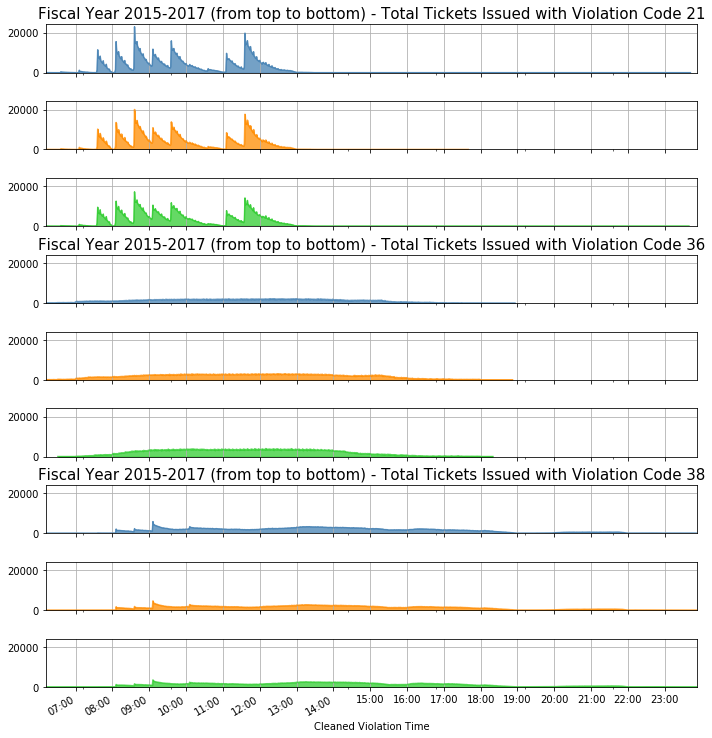

In [94]:
fig, axes = plt.subplots(9,1, sharex = True, sharey = True)

for i,j in zip([21,36,38],[0,3,6]):
    plt.tight_layout()
    for data, year, k in zip(data_151617,years, range(3)):
        vcode_hour_data = data[['Violation Time', 'Summons Number', 'Violation Code']]
        vcode_hour_data = vcode_hour_data.loc[vcode_hour_data['Violation Code'] == i]
        vcode_hour_data = vcode_hour_data.groupby('Violation Time', as_index = False).count()
        #I found this is a very effective way to filter all invalid data entries since they are all infrequent events.
        vcode_hour_data = vcode_hour_data.loc[vcode_hour_data['Summons Number'] > 10] 
        vcode_hour_data = vcode_hour_data.rename(columns = {'Summons Number' : 'Total Tickets'})
        vcode_hour_data['Cleaned Violation Time'] = vcode_hour_data['Violation Time'].apply(cleanViolationTime)
        vcode_hour_data = vcode_hour_data.loc[vcode_hour_data['Cleaned Violation Time'].dt.year == 1960]
        vcode_hour_data = vcode_hour_data.groupby('Cleaned Violation Time').sum()
        
        if k == 0:
            color = 'steelblue'
        elif k == 1:
            color = 'darkorange'
        else:
            color = 'limegreen'
        vcode_hour_data['Total Tickets'].plot(ax = axes[k+j], figsize = (10,12), grid = True, kind = 'area', alpha = 0.75, color = color)
        axes[k+j].xaxis.set_major_locator(dates.HourLocator())
        axes[k+j].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
        if k == 0:
            axes[k+j].set_title("Fiscal Year 2015-2017 (from top to bottom) - Total Tickets Issued with Violation Code " + str(i),fontsize = 15)


It seems that the pattern of total number of tickets in section 3 was contributed mainly by tickets issued with violation code 21.

Now, let's remove the data with the violation code 21 from the orignal dataset to see whetehr the peaks disappear or not

<a id = '6'></a>
## 6. Total Ticket Issued on Different Hours of the Day - Excluding Data with Violation Code 21 

Text(0.5, 1.0, 'Total Ticket Issued on Different Hours of the Day - Excluding Data with Violation Code 21 ')

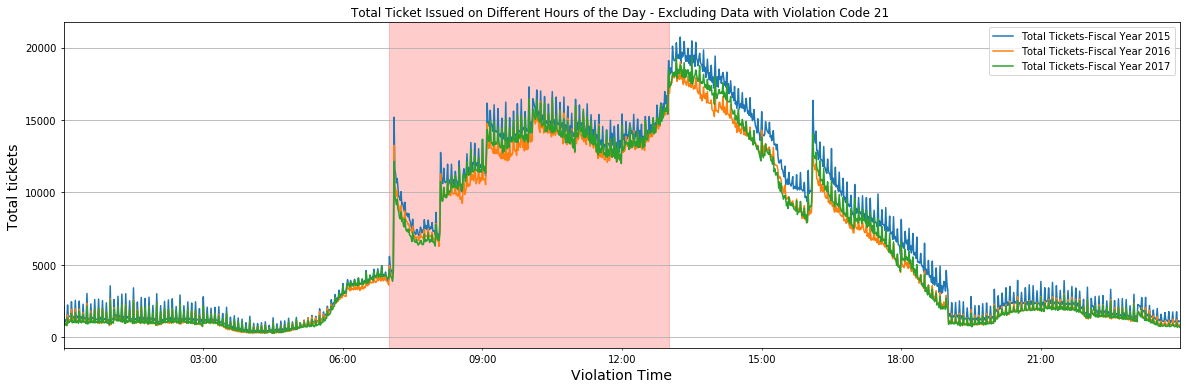

In [99]:
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1,1,1)
for data, year in zip(data_151617, years):
    #Cleanning the dataset
    v_code_data = data[['Violation Time', 'Summons Number','Violation Code']]
    v_code_data = v_code_data.loc[v_code_data['Violation Code'] != 21]
    v_code_data = v_code_data.groupby('Violation Time', as_index = False).count()
    v_code_data = v_code_data.drop('Violation Code', axis = 1)
    v_code_data = v_code_data.loc[v_code_data['Summons Number'] > 10] #I found this is a very effective way to filter all invalid data entries since they are all infrequent events.
    v_code_data['Cleaned Violation Time'] = v_code_data['Violation Time'].apply(cleanViolationTime)
    v_code_data = v_code_data.loc[v_code_data['Cleaned Violation Time'].dt.year == 1960].groupby('Cleaned Violation Time').sum()
    v_code_data = v_code_data.rename(columns = {'Summons Number' : ('Total Tickets-Fiscal Year ' + str(year))})
    #graph section
    v_code_data.plot(ax = ax, kind = 'line', grid = True, alpha = 1)
    ax.set_xlabel("Violation Time", fontsize = 14)
    ax.set_ylabel("Total tickets", fontsize = 14)
    ax.xaxis.set_major_locator(dates.HourLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax.axvspan('1960-01-01 07:00','1960-01-01 13:00', alpha = 0.2, color = 'red' )
plt.title('Total Ticket Issued on Different Hours of the Day - Excluding Data with Violation Code 21 ')


It looks like the peaks shown in section 3 are gone, I think it is reasonable for us to conclude now that those peaks were caused by tickets with violation code 21. 

<a id = '7'></a>
## 7. Total Tickets and Plate Types

Now, let's investigate which type of vehicle has the most tickets issued. To do this, I have decided to use heatmaps such that we could have quick and informative views about the total tickets each plate type has based on the month and weekday.

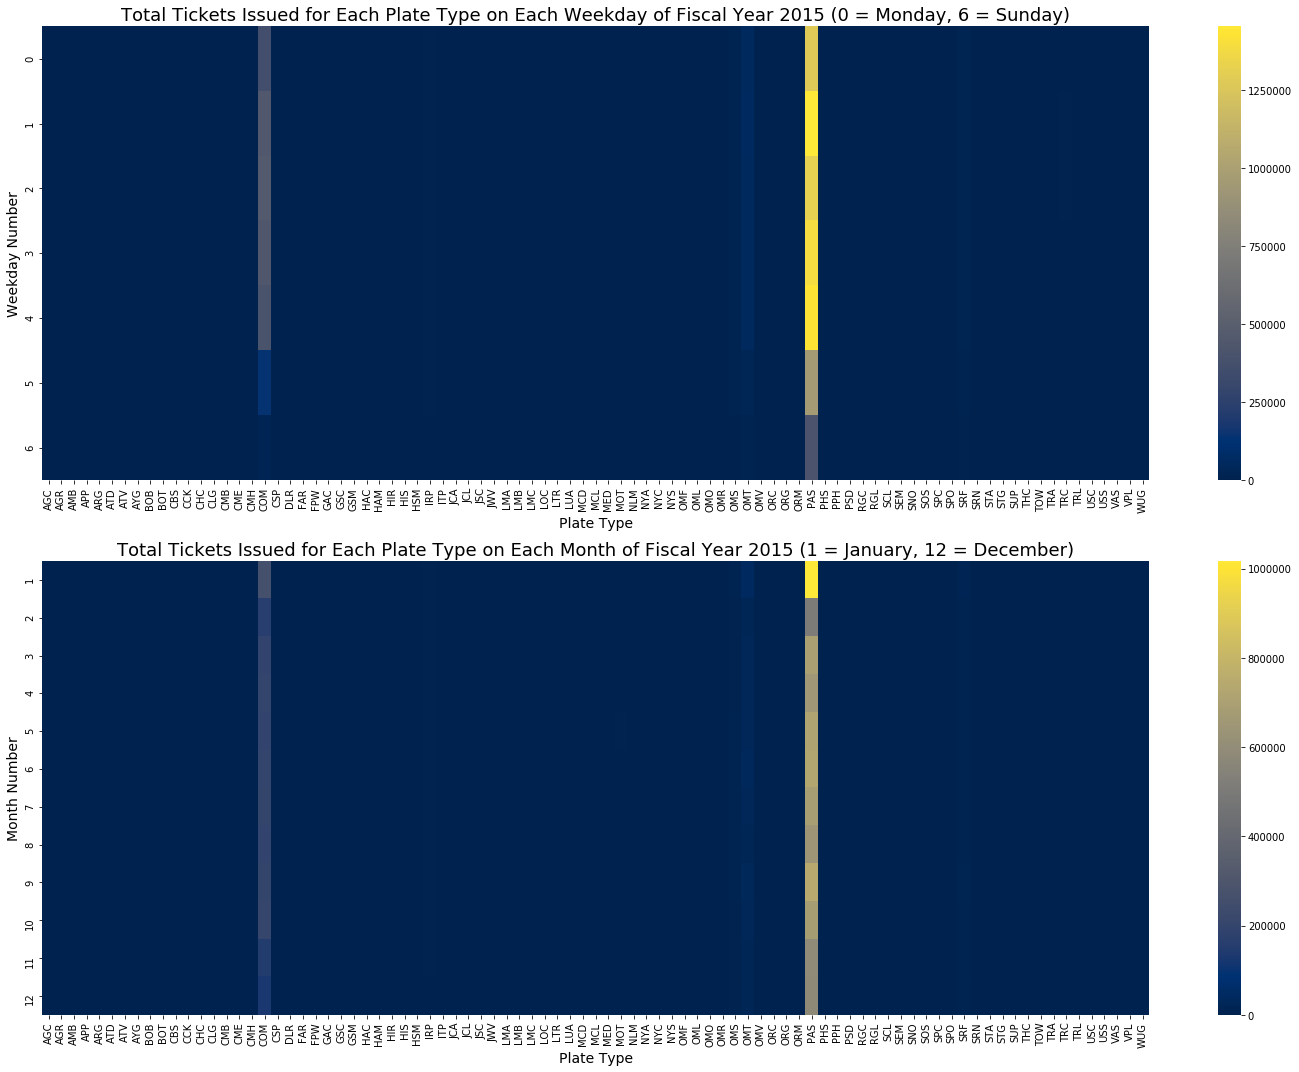

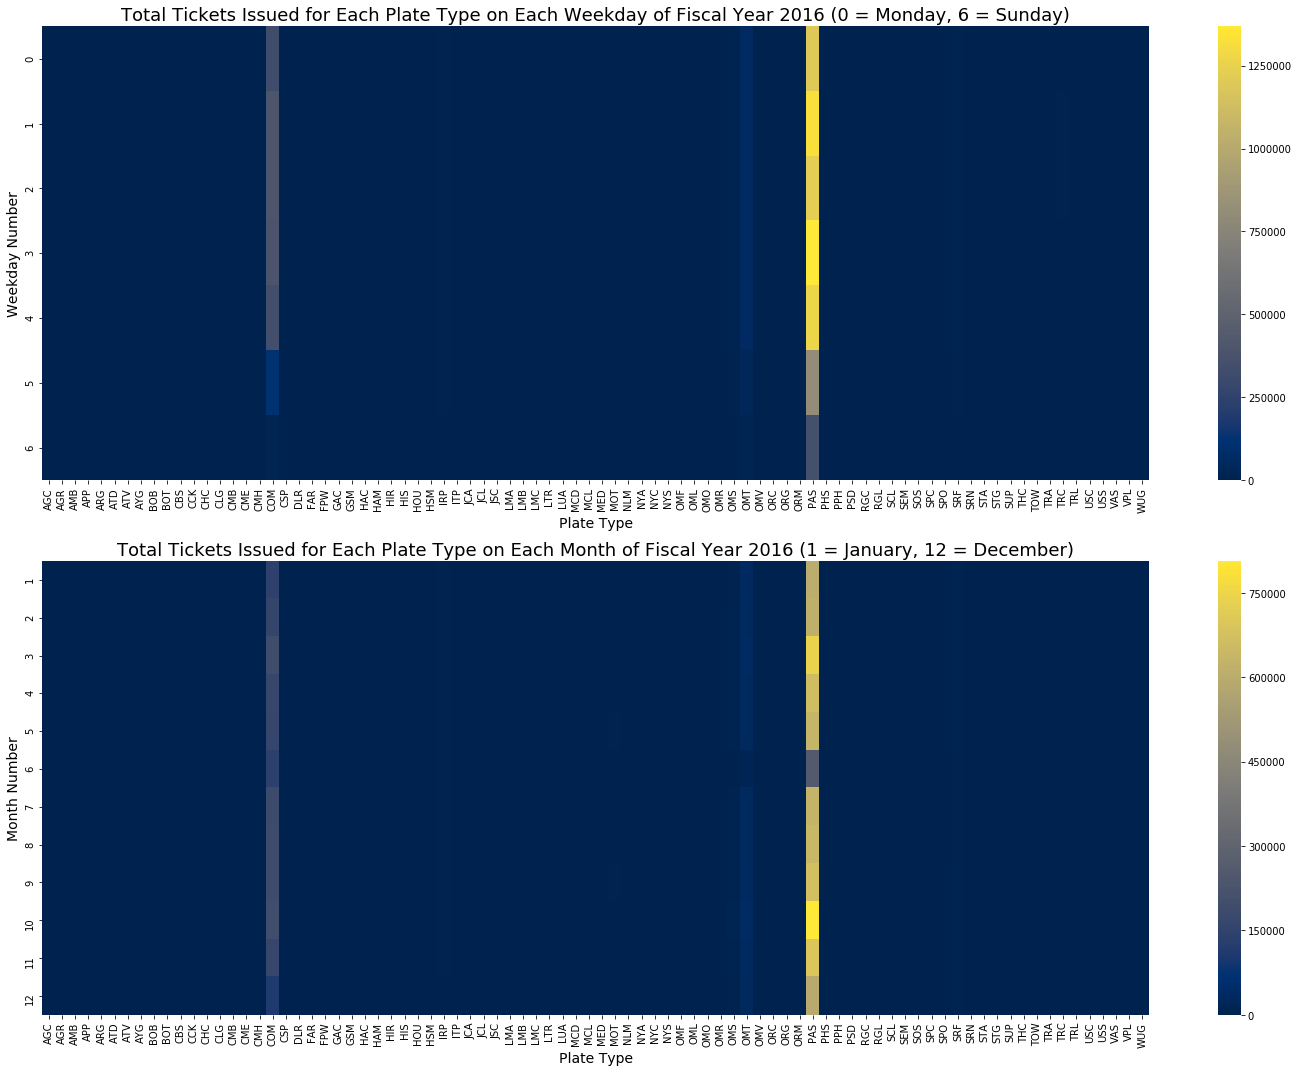

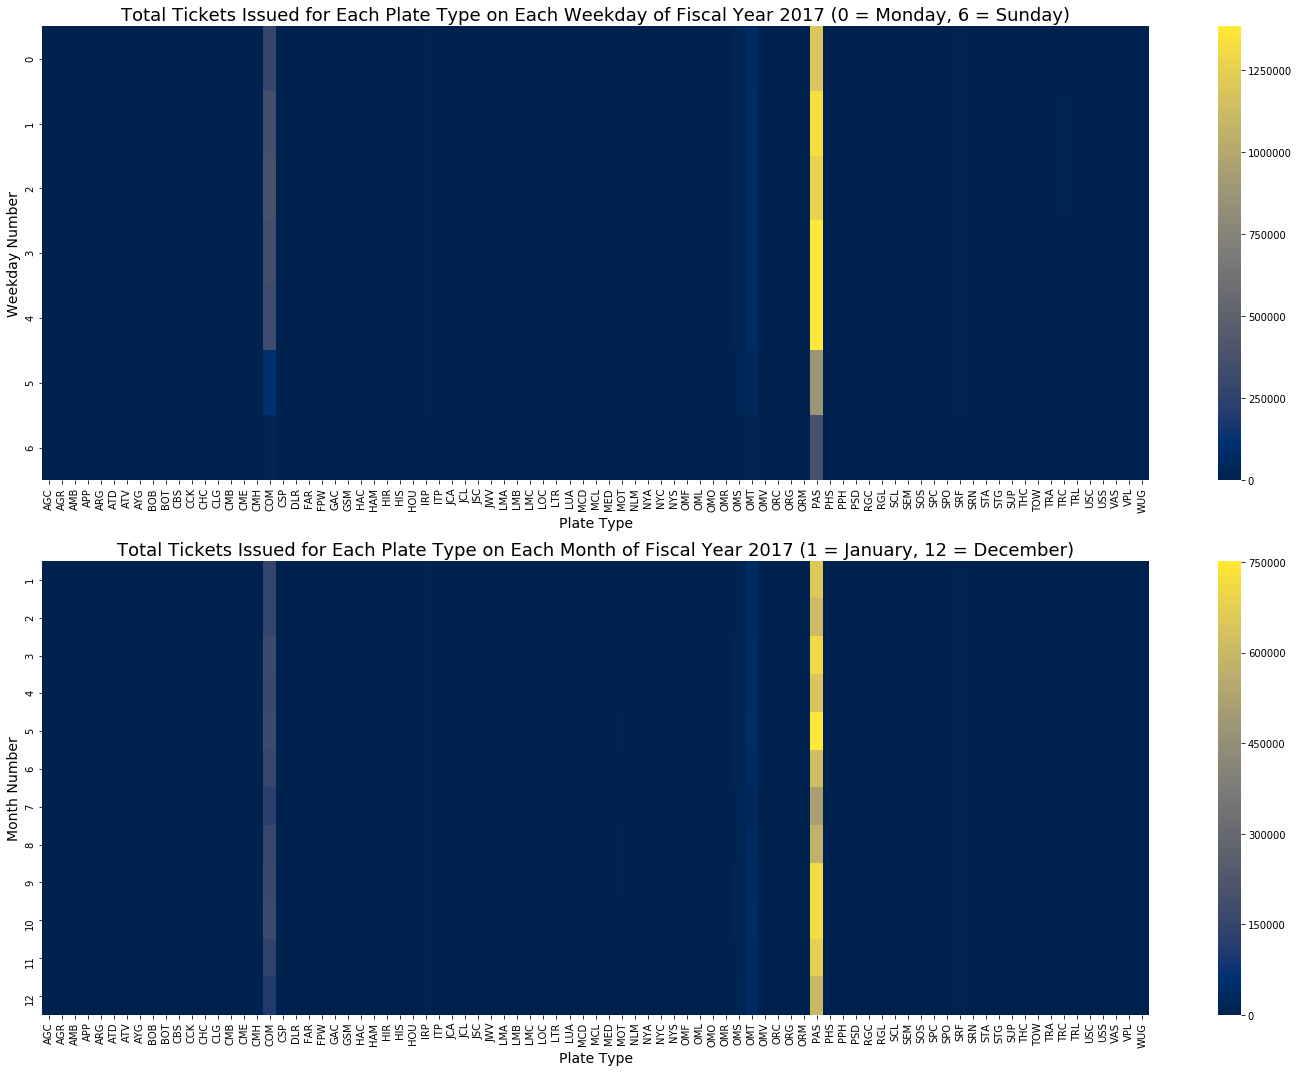

In [100]:
for data, start_date, end_date, year in zip(data_151617, start_dates, end_dates, years): 
    #Prepare the dataset
    Date_PT_TotalTX = data[['Issue Date','Plate Type','Summons Number']]
    Date_PT_TotalTX = Date_PT_TotalTX.groupby(['Issue Date','Plate Type'], as_index = False).count()
    Date_PT_TotalTX['Issue Date'] = pd.to_datetime(Date_PT_TotalTX['Issue Date'])
    Date_PT_TotalTX = Date_PT_TotalTX.set_index('Issue Date')
    Date_PT_TotalTX = Date_PT_TotalTX.loc[start_date:end_date]
    Date_PT_TotalTX = Date_PT_TotalTX.loc[Date_PT_TotalTX['Plate Type'] != '999']
    Date_PT_TotalTX['Month Number'] = Date_PT_TotalTX.index.month
    Date_PT_TotalTX['Weekday Number'] = Date_PT_TotalTX.index.weekday
    Weekday_PT_TotalTX = Date_PT_TotalTX.groupby(['Weekday Number', 'Plate Type']).sum()
    Month_PT_TotalTX = Date_PT_TotalTX.groupby(['Month Number','Plate Type']).sum()

    #Tranform the table for heat plot
    Weekday_PT_TotalTX = Weekday_PT_TotalTX.reset_index()
    Month_PT_TotalTX = Month_PT_TotalTX.reset_index()
    Weekday_PT_TotalTX = Weekday_PT_TotalTX.pivot(index = 'Weekday Number', columns = 'Plate Type', values = 'Summons Number')
    Weekday_PT_TotalTX = Weekday_PT_TotalTX.fillna(0)
    Month_PT_TotalTX = Month_PT_TotalTX.pivot(index='Month Number', columns='Plate Type', values='Summons Number')
    Month_PT_TotalTX = Month_PT_TotalTX.fillna(0)

    #Making Heatmap
    fig, axes = plt.subplots(2,1, figsize=(20,15)) 
    sns.heatmap(ax = axes[0], data = Weekday_PT_TotalTX, cmap = "cividis")
    axes[0].set_title("Total Tickets Issued for Each Plate Type on Each Weekday of Fiscal Year " + str(year) + " (0 = Monday, 6 = Sunday)",fontsize = 18)
    axes[0].set_xlabel("Plate Type", fontsize = 14)
    axes[0].set_ylabel("Weekday Number", fontsize = 14)
    sns.heatmap(ax = axes[1], data = Month_PT_TotalTX, cmap = "cividis")
    axes[1].set_title("Total Tickets Issued for Each Plate Type on Each Month of Fiscal Year " + str(year) + " (1 = January, 12 = December)",fontsize = 18 )
    axes[1].set_xlabel("Plate Type", fontsize = 14)
    axes[1].set_ylabel("Month Number", fontsize = 14)
    plt.tight_layout()

It looks like the passenger cars (PAS) has the most tickets issued in almost every row in the above heatmaps.  

This is consistent with our previous finding that violation code 21 is the one that the most ticket issued for, recall that violation code 21 is for Street Cleaning violation, and considering that most of the NYC area is residential, hence, the type of vehicle that has the highest probability to violate the code 21 is probably the passenger cars.

<a id = '8'></a>
## 8. Total Tickets Issued by Each Precinct of NYC 

So far, we have answer the question regarding how the data of the parking tickets is distributed based on time and plate types, but the question about locations of each tickets issued has not been investigated yet. So, lets't do that now. ;-)

To generate a NYC map with the number of tickets issued, we need the columns that contains the geographic information from the dataset, and also, the column must not have too many missing entries such that it is fairly represnetative relative to the total tickets number we calculated. After compare all columns contains the geographic information, I decided to pick the 'Issuer precinct' column since it fits the above requirments.

The shapefile I used for the NYC precinct map could be found here:
https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz

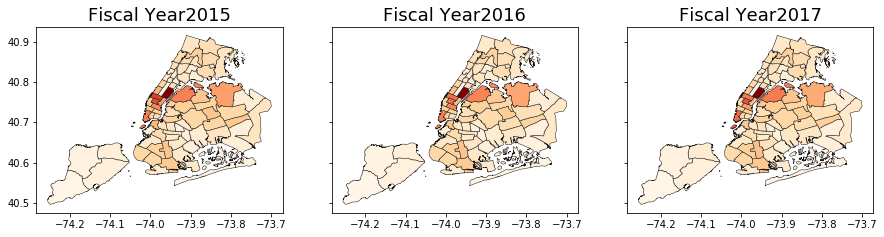

In [101]:
Precinct_TotalTX_list = []
fig, axes = plt.subplots(1,3, figsize = (15,15), sharey = True)
for i, data, start_date, end_date, year in zip(range(3), data_151617, start_dates, end_dates, years):   
    #Dataset preparation
    Date_Precinct_TotalTX = data[['Issue Date','Issuer Precinct','Summons Number']]
    #Group data based on issue date and precinct
    Date_Precinct_TotalTX = Date_Precinct_TotalTX.groupby(['Issue Date','Issuer Precinct'], as_index = False).count()
    Date_Precinct_TotalTX['Issue Date'] = pd.to_datetime(Date_Precinct_TotalTX['Issue Date'])
    Date_Precinct_TotalTX = Date_Precinct_TotalTX.set_index('Issue Date')
    #locate data within the approporiate fiscal year range
    Date_Precinct_TotalTX = Date_Precinct_TotalTX[start_date:end_date]
    #Group data base on precinct
    Precinct_TotalTX = Date_Precinct_TotalTX.groupby('Issuer Precinct').sum()
    #remove invalid precinct entries
    Precinct_TotalTX = Precinct_TotalTX[1:124]
    Precinct_TotalTX = Precinct_TotalTX.drop([2,3,4,8,11,12,15,16,21,27,29,31,35,36,37,38,39,51,53,54,55,56,57,58,59,64,65,74,80,82,85,86,87,89,91,92,93,95,96,97,98,99,116,117,118,119])
    Precinct_TotalTX_list.append(Precinct_TotalTX)
    #Graph section Precinct Heat Map
    map_path = "./precinct_map/geo_export_1ac7dc26-ca74-4ae0-8bef-28d6099c5e96.shp"
    data = gpd.read_file(map_path)
    data = data.set_index('precinct')
    data = pd.concat([data,Precinct_TotalTX], axis = 1)
    data.plot(ax = axes[i], column='Summons Number', legend = False, cmap = 'OrRd',linewidth = 0.5, edgecolor = 'k')
    axes[i].set_title( 'Fiscal Year'  + str(year), Fontsize = 18)
    

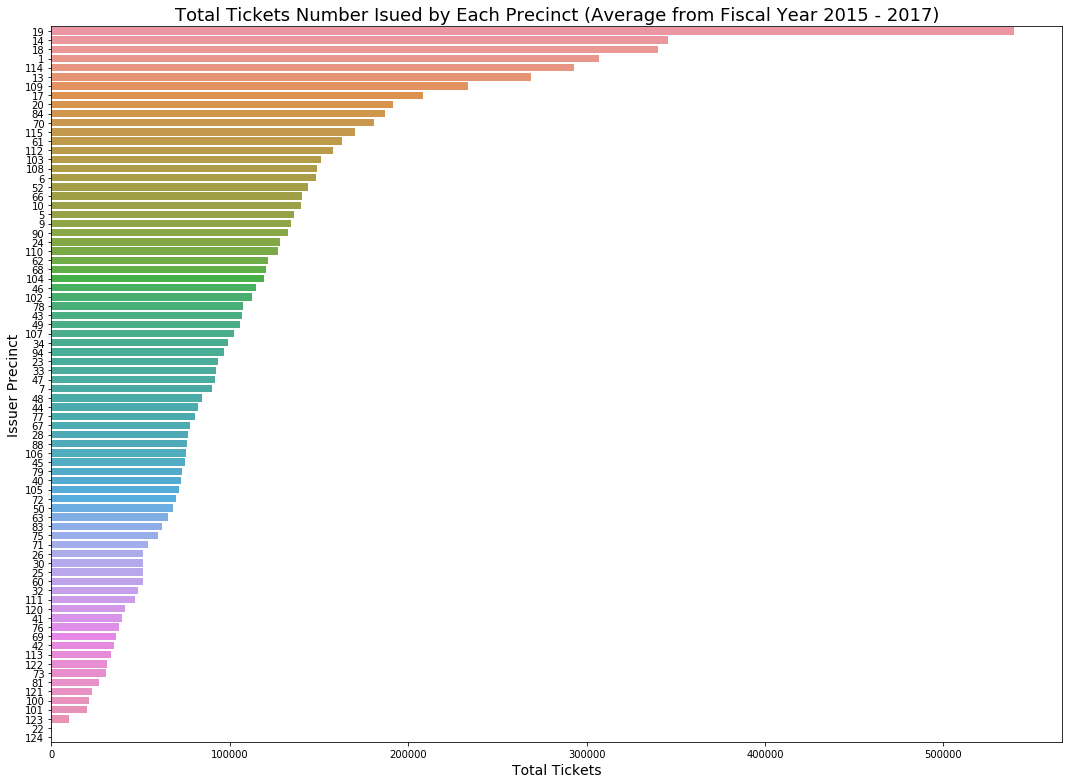

In [102]:
fig = plt.figure(figsize = (15,11))
ax = fig.add_subplot(1,1,1)
Precinct_TotalTX = (Precinct_TotalTX_list[0]+Precinct_TotalTX_list[1]+Precinct_TotalTX_list[2])/3
Precinct_TotalTX = Precinct_TotalTX.reset_index().sort_values('Summons Number', ascending = False).rename(columns = {'Summons Number':'Total Tickets'})
Precinct_TotalTX['Issuer Precinct'] = Precinct_TotalTX['Issuer Precinct'].apply(int)
# Considering there are ~7500 tickets issued every minute in NYC, violation codes with annual ticket sum less than 10,000 is omitted in this graph
#Precinct_TotalTX_list = Precinct_TotalTX_list.loc[Precinct_TotalTX_list['Total Tickets'] > 10000]
sns.set_color_codes("pastel")
sns.barplot(x="Total Tickets", y="Issuer Precinct", data=Precinct_TotalTX, orient = 'h', order = Precinct_TotalTX['Issuer Precinct'])
ax.set_title('Total Tickets Number Isued by Each Precinct (Average from Fiscal Year 2015 - 2017)', fontsize = 18)
ax.set_xlabel("Total Tickets", fontsize = 14)
ax.set_ylabel("Issuer Precinct", fontsize = 14)
plt.tight_layout()

A complete list of NYC precinct can be found here:
https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page

As we can see from the above graph, all top three issuer precincts are from Manhattan, and the numbers are consistent throughout three fiscal years:

- Precinct 19 - The 19th Precinct command serves the Upper East Side of Manhattan. The precinct is one of the most densely populated residential areas in Manhattan. The southern part of the precinct has a large commercial area and features Madison, Lexington, and 3rd Avenues, which are well known for their shopping.

- Precinct 14 (Midtown South Precinct) - As its name implies, the Midtown South Precinct serves the southern portion of Midtown, Manhattan. The area contains commercial offices, hotels, Times Square, Grand Central Terminal, Penn Station, Madison Square Garden, Koreatown section, and the Manhattan Mall Plaza.

- Precinct 18 (Midtown North Precinct) - The Midtown North Precinct serves the area of Midtown, Manhattan, just south of Central Park. The precinct encompasses the Diamond District, St. Patrick's Cathedral, the Theatre District, Restaurant Row, Radio City Music Hall, and Rockefeller Plaza.
